In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph as ig
from collections import Counter
import pickle
import math
import random
import copy
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

from src import acgraph as acg
from src import bcloader as bcl
from src import utils as ut
from src import bcgraph as bcg
from src import avpattern as avp
from efficient_apriori import apriori

from importlib import reload
acg = reload(acg)
bcl = reload(bcl)
bcg = reload(bcg)


In [3]:
rel_attnames = [
#'MGR_ID',
#'ROLE_ROLLUP_1',
'ROLE_ROLLUP_2',
'ROLE_DEPTNAME',
'ROLE_TITLE',
'ROLE_FAMILY_DESC',
'ROLE_FAMILY']
gur = acg.load_azkag_graph(rel_attnames=rel_attnames, isWeighted=True)
print('---Control Access Graph---')
print('Total edges:', len(gur.es))
print('Total vertices:', len(gur.vs))

gur_usrlabels,gur_reslabels = acg.get_labels(gur, byweights=False)
print('Num users:',len(gur_usrlabels))
print('Num resources:', len(gur_reslabels))
print()

gur = acg.get_largestcc(gur)
print('---Largest Connected Component---')
print('Total edges:', len(gur.es))
print('Total vertices:', len(gur.vs))
usrlabels,reslabels = acg.get_labels(gur, byweights=False)
print('Num users:',len(usrlabels))
print('Num resources:', len(reslabels))

---Control Access Graph---
Total edges: 30872
Total vertices: 16524
Num users: 9298
Num resources: 7226

---Largest Connected Component---
Total edges: 30425
Total vertices: 15773
Num users: 8933
Num resources: 6840


In [4]:
def res_requesters_distrib(usrvidx_resvidx_tups):
    resvidxset = set()
    for tup in usrvidx_resvidx_tups:
        resvidxset.add(tup[1])
    num_requesters = []
    for resvidx in list(resvidxset):
        num_requesters.append(len(gur.neighbors(resvidx)))

    num_requesters_to_freq = dict(Counter(num_requesters))
    num_requesters_to_freq = dict(sorted(num_requesters_to_freq.items(), key=lambda item: item[1]))
    totalf = sum(num_requesters_to_freq.values())

    x = num_requesters_to_freq.keys()
    y = [f/totalf for f in num_requesters_to_freq.values()]
    plt.loglog(x, y, '.')
    plt.xlabel('num requesters')
    plt.ylabel('p')
    plt.show()

In [5]:
userlog_objs = []
for v in gur.vs:
    if v['type'] == False:
        userlog_obj = []
        for attname in v.attribute_names():
            if not attname in ['type','name']:
                userlog_obj.append(v[attname])
        userlog_objs.append(userlog_obj)
userlog_objs = ut.to_tuple_format(userlog_objs)

resvidx_to_neighattvals = dict()
for vidx,v in enumerate(gur.vs):
    if v['type'] == True:
        neighattvals = set()
        for usrvidx in gur.neighbors(v):
            neighattvals |= set(userlog_objs[usrvidx])
            
        resvidx_to_neighattvals[vidx] = list(neighattvals)

In [6]:
def cosine_sim(gur, usrvidx, resvidx):
    uv = gur.vs[usrvidx]
    rv = gur.vs[resvidx]
    uneighs = gur.neighbors(uv)
    uneighs2 = set()
    for resvidx in uneighs:
        uneighs2 |= set(gur.neighbors(gur.vs[resvidx]))   
    rneighs = gur.neighbors(rv)
    cs = len(set(uneighs2)&set(rneighs))/math.sqrt(len(uneighs)*len(rneighs))
    return cs

In [7]:
def next_vertex(gur, v):
    neighvidxs = gur.neighbors(v)
    i = random.randint(0,len(neighvidxs)-1)
    return gur.vs[neighvidxs[i]]
    

def get_entry_tupes(gur, max_hops, alpha, sd):
    random.seed(sd)
    usrvidx_resvidx_tups = list()
    
    for v in gur.vs:
        if v['type']: #Only resources
            neighvidxsset = set(gur.neighbors(v))
            deg = len(neighvidxsset)
            usrvidxsset = set()

            v_ = v
            count = 0
            while len(usrvidxsset) < alpha*deg:
                for i in range(max_hops):
                    v2 = next_vertex(gur, v_)
                    if i == max_hops-1 and not v2.index in neighvidxsset:
                        usrvidxsset.add(v2.index)
                    else:
                        v_ = v2
                count += 1
                
                if count > 100000:
                    break

            for usrvidx in list(usrvidxsset):
                usrvidx_resvidx_tups.append((usrvidx,v.index))              
        
    return usrvidx_resvidx_tups


def filter_sim(gur, usrvidx_resvidx_tups, thmin, thmax):
    usrvidx_resvidx_tups_ = []
    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        cs = cosine_sim(gur, usrvidx, resvidx)
        if cs > thmin and cs <= thmax:
            usrvidx_resvidx_tups_.append(tup)
    
    return usrvidx_resvidx_tups_


def filter_atts(gur, usrvidx_resvidx_tups, minth, maxth):
    usrvidx_resvidx_tups_ = []
    
    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        
        usrattvalsset = set(userlog_objs[usrvidx])
        neighattvalsset = set(resvidx_to_neighattvals[resvidx])
        
        x = len(usrattvalsset&neighattvalsset)
        if x > minth and x <= maxth:
            usrvidx_resvidx_tups_.append(tup)
            
    return usrvidx_resvidx_tups_
    
    

In [8]:
usrvidx_resvidx_tups = get_entry_tupes(gur, max_hops=5, alpha=5, sd=13)

In [9]:
len(usrvidx_resvidx_tups)

152125

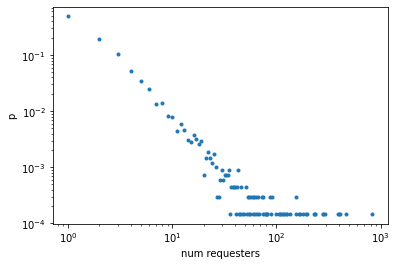

In [10]:
res_requesters_distrib(usrvidx_resvidx_tups)

In [11]:
usrvidx_resvidx_tups_ = filter_sim(gur, usrvidx_resvidx_tups, thmin=0.05, thmax=0.2)

In [12]:
len(usrvidx_resvidx_tups_)

6922

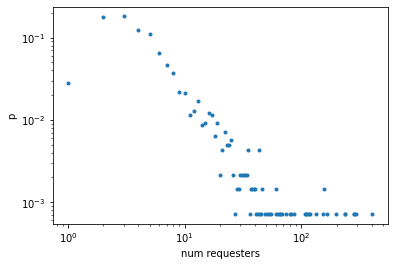

In [13]:
res_requesters_distrib(usrvidx_resvidx_tups_)

In [14]:
usrvidx_resvidx_tups_neg = filter_atts(gur, usrvidx_resvidx_tups_, minth=0, maxth=10)

In [15]:
len(usrvidx_resvidx_tups_neg)

4138

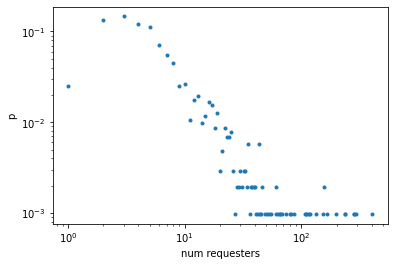

In [16]:
res_requesters_distrib(usrvidx_resvidx_tups_neg)

In [17]:
usrvidx_resvidx_tups = get_entry_tupes(gur, max_hops=3, alpha=10, sd=43)

In [18]:
len(usrvidx_resvidx_tups)

302420

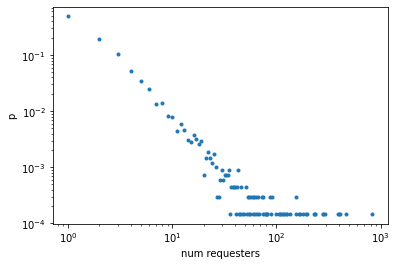

In [19]:
res_requesters_distrib(usrvidx_resvidx_tups)

In [20]:
usrvidx_resvidx_tups_ = filter_sim(gur, usrvidx_resvidx_tups, thmin=0.2, thmax=100)

In [21]:
len(usrvidx_resvidx_tups_)

19546

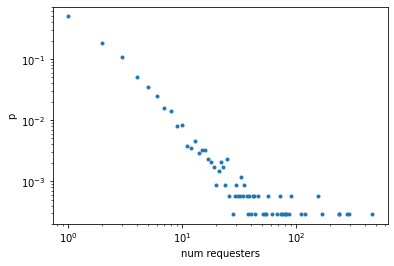

In [22]:
res_requesters_distrib(usrvidx_resvidx_tups_)

In [23]:
usrvidx_resvidx_tups_pos = filter_atts(gur, usrvidx_resvidx_tups_, minth=3, maxth=10)

In [24]:
len(usrvidx_resvidx_tups_pos)

1888

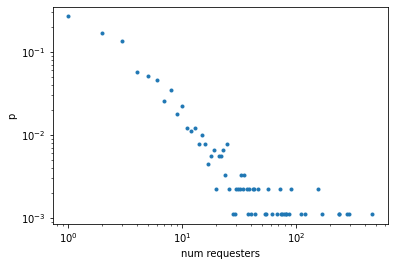

In [25]:
res_requesters_distrib(usrvidx_resvidx_tups_pos)

### Evaluate biclique graph patterns

In [26]:
with open('data_structures/maxcc_azkag_bcs_v2.pkl', 'rb') as f:
    bcs = pickle.load(f)

print('Total bicliques:', len(bcs))

Total bicliques: 17563


In [27]:
subbcs = []
for bc in bcs:
    if bc.get_pattern() != None and len(bc.get_pattern()) >= 1:
        nusr = len(bc.get_usrids())
        nres = len(bc.get_resids())
        subbcs.append(bc)

print('Selected bicliques:', len(subbcs))

Selected bicliques: 12263


In [28]:
with open('data_structures/azkag_bcgraph.pkl', 'rb') as f:
    bcgraph = pickle.load(f)

In [29]:
bcid_to_bc = {bc.get_id():bc for bc in subbcs}
bcg = reload(bcg)
gps = bcg.dfs(bcgraph, bcid_to_bc, sa=1)
print('Num graph patterns:', len(gps))

Num graph patterns: 6886


In [31]:
gps_final = []
for gpidx,gp in enumerate(gps):
    if len(gp[1]) < 50:
        gps_final.append(gp)

gps_final = [gp for gp in gps_final if len(gp[0])>1]

In [32]:
len(gps_final)

6375

In [35]:
#Create mappings
rules = [gp[0] for gp in gps_final]

bcid_to_ruleidxs = dict()
for ruleidx,gp in enumerate(gps_final):
    for bcid in gp[1]:
        if not bcid in bcid_to_ruleidxs:
            bcid_to_ruleidxs[bcid] = []
        bcid_to_ruleidxs[bcid].append(ruleidx)
        
#Agregado debido que ahora cargo el grafo de respaldo
bcid_to_bcidx = dict()
for bcidx,bc in enumerate(subbcs):
    bcid = bc.get_id()
    bcid_to_bcidx[bcid] = bcidx
    
resid_to_bcids = dict()
for bcv in bcgraph.vs:
    bcid = bcv['bcid']
    bc = subbcs[bcid_to_bcidx[bcid]]
    resids_ = bc.get_resids()
    for resid in resids_:
        if not resid in resid_to_bcids:
            resid_to_bcids[resid] = []
        resid_to_bcids[resid].append(bcid) 

In [39]:
def evaluate_bgp(gur, usrvidx_resvidx_tups):

    num_valid = 0
    num_trues = 0

    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        usrattvals = userlog_objs[usrvidx]
        resid = int(gur.vs[resvidx]['name'][6:])

        if resid in resid_to_bcids:
            ruleidxs = set()
            for bcid in resid_to_bcids[resid]:
                if bcid in bcid_to_ruleidxs:
                    ruleidxs |= set(bcid_to_ruleidxs[bcid])

            ruleidxs = list(ruleidxs)

            if len(ruleidxs) > 0:
                num_valid += 1

            for ruleidx in ruleidxs:
                rule = rules[ruleidx]
                if len(set(usrattvals)&set(rule)) == len(rule):
                        num_trues += 1
                        break
                        
    return num_valid, num_trues
            
            

In [50]:
random.seed(13)
n = len(usrvidx_resvidx_tups_pos)
usrvidx_resvidx_tups_neg_sam = random.sample(usrvidx_resvidx_tups_neg,n)

num_pos, num_truepos = evaluate_bgp(gur, usrvidx_resvidx_tups_pos)
num_neg, num_falsepos = evaluate_bgp(gur, usrvidx_resvidx_tups_neg_sam)
print('TPR', num_truepos/num_pos)
print('FPR', num_falsepos/num_neg)

recall = num_truepos/num_pos
precision = num_truepos/(num_truepos+num_falsepos)
fscore = 2*recall*precision/(recall+precision)
print('Fscore:', fscore)

TPR 0.7711864406779662
FPR 0.20233050847457626
Fscore: 0.7815351583467526


### Evaluation frequent patterns

In [53]:
global_f = 5
resid_to_valsentries,resid_to_patterns=\
avp.compute_avpatterns(gur, lmin=2, global_f=global_f, verbose=False)

In [56]:
def evaluate_fp(gur, usrvidx_resvidx_tups):
    num_valid = 0
    num_trues = 0
    for tup in usrvidx_resvidx_tups:
        usrvidx = tup[0]
        resvidx = tup[1]
        usrattvals = userlog_objs[usrvidx]
        resid = int(gur.vs[resvidx]['name'][6:])

        if len(resid_to_patterns[resid]) > 0:
            num_valid += 1

        for rule in resid_to_patterns[resid]:
            if len(set(usrattvals)&set(rule)) == len(rule):
                    num_trues += 1
                    break
                    
    return num_valid, num_trues
    

In [57]:
random.seed(13)
n = len(usrvidx_resvidx_tups_pos)
usrvidx_resvidx_tups_neg_sam = random.sample(usrvidx_resvidx_tups_neg,n)

num_pos, num_truepos = evaluate_fp(gur, usrvidx_resvidx_tups_pos)
num_neg, num_falsepos = evaluate_fp(gur, usrvidx_resvidx_tups_neg_sam)
print('TPR', num_truepos/num_pos)
print('FPR', num_falsepos/num_neg)

recall = num_truepos/num_pos
precision = num_truepos/(num_truepos+num_falsepos)
fscore = 2*recall*precision/(recall+precision)
print('Fscore:', fscore)

TPR 0.5631517960602549
FPR 0.15505226480836237
Fscore: 0.6365422396856582


In [60]:
num_falsepos

178

In [62]:
num_neg

1148

In [ ]:
#Fscore mas bajo para fp
#Porque con esta generacion de muestras, muestro para recursos poco solicitados